In [2]:
import numpy as np
import os
import pandas as pd
#import tensorflow as tf

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Exploring the data

In [3]:
from IPython.display import display, Image

In [93]:
os.listdir('input')

['.DS_Store', 'test', 'train', 'train.csv', 'sample_submission.csv']

In [5]:
train_df = pd.read_csv('input/train.csv')
submission_df = pd.read_csv('input/sample_submission.csv')

In [6]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.5+ KB


In [8]:
train_df.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xb29175a20>]],
      dtype=object)

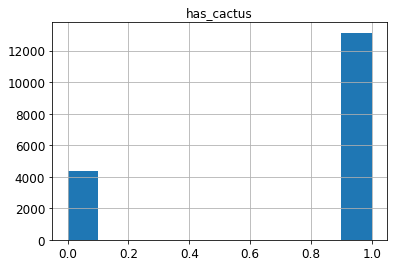

In [10]:
train_df.hist()

In [11]:
print("Number of rows in submission/test set: %d"%(len(submission_df)))

Number of rows in submission/test set: 4000


In [12]:
train_dir = "input/train"  # "../input/train/train/" for kernel submission

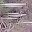

In [13]:
im = Image(os.path.join(train_dir,train_df.iloc[0,0]), height=200, width=200)
display(im)

In [14]:
image = plt.imread(os.path.join(train_dir,train_df.iloc[0,0]))
image.shape

(32, 32, 3)

In [15]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

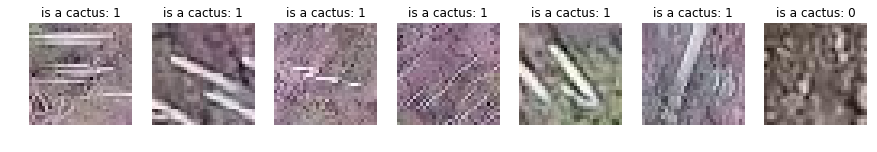

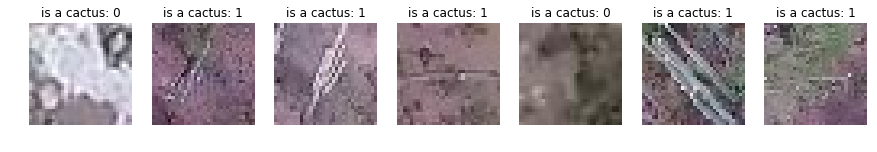

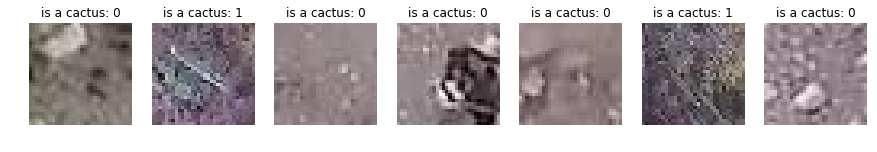

In [25]:
list_of_images = []
list_of_titles = []

for i in range(21):
    list_of_images.append(plt.imread(os.path.join(train_dir,train_df.iloc[i,0])))
    list_of_titles.append('is a cactus: {}'.format(train_df.iloc[i,1]))

grid_display(list_of_images, list_of_titles, no_of_columns= 7, figsize = (15,15))

### Generating train and validation sets

In [26]:
from keras.preprocessing.image import ImageDataGenerator

In [45]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [46]:
print('size train: {}, size validation: {}'.format(17500*0.8, 17500*0.2))

size train: 14000.0, size validation: 3500.0


In [35]:
train_df.has_cactus=train_df.has_cactus.astype(str)

In [47]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir, subset='training', 
                                              x_col='id', y_col='has_cactus', class_mode='binary', 
                                              batch_size= 140, target_size=(32,32))


validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir, subset='validation', 
                                                   x_col='id', y_col='has_cactus', class_mode='binary', 
                                                   batch_size= 35, target_size=(32,32))

Found 14000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


### CNN model

In [49]:
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,Flatten,Dropout,MaxPool2D

In [50]:
model = Sequential()

In [51]:
model.add(Convolution2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 128)         73856     
__________

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=40, 
                              validation_data=validation_generator, validation_steps=100)

Epoch 1/40
100/100 [==============================] - 52s 524ms/step - loss: 0.3546 - acc: 0.8482 - val_loss: 0.1895 - val_acc: 0.9334
Epoch 2/40
100/100 [==============================] - 58s 578ms/step - loss: 0.1536 - acc: 0.9423 - val_loss: 0.1336 - val_acc: 0.9537
Epoch 3/40
100/100 [==============================] - 54s 540ms/step - loss: 0.1214 - acc: 0.9548 - val_loss: 0.1047 - val_acc: 0.9649
Epoch 4/40
100/100 [==============================] - 50s 498ms/step - loss: 0.1075 - acc: 0.9589 - val_loss: 0.0893 - val_acc: 0.9666
Epoch 5/40
100/100 [==============================] - 51s 514ms/step - loss: 0.0845 - acc: 0.9689 - val_loss: 0.0950 - val_acc: 0.9669
Epoch 6/40
100/100 [==============================] - 62s 625ms/step - loss: 0.0778 - acc: 0.9716 - val_loss: 0.0753 - val_acc: 0.9731
Epoch 7/40
100/100 [==============================] - 49s 492ms/step - loss: 0.0689 - acc: 0.9745 - val_loss: 0.0910 - val_acc: 0.9663
Epoch 8/40
100/100 [==============================] - 4

### Learning Curves

In [60]:
def plot_LC(history):
    loss=history.history['loss']    ##getting  loss of each epochs
    n_epochs = len(loss)
    epochs_=range(0,n_epochs)
    plt.plot(epochs_,loss,label='training loss')
    plt.xlabel('No of epochs')
    plt.ylabel('loss')

    acc_val=history.history['val_loss']  ## getting validation loss of each epochs
    plt.scatter(epochs_,acc_val,label="validation loss")
    plt.title('No of epochs vs loss')
    plt.legend()
    plt.show()

In [61]:
def plot_acc(history):
    acc=history.history['acc']  ##getting  accuracy of each epochs
    n_epochs = len(acc)
    epochs_=range(0,n_epochs)    
    plt.plot(epochs_,acc,label='training accuracy')
    plt.xlabel('No of epochs')
    plt.ylabel('accuracy')

    acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
    plt.scatter(epochs_,acc_val,label="validation accuracy")
    plt.title("No of epochs vs accuracy")
    plt.legend()
    plt.show()

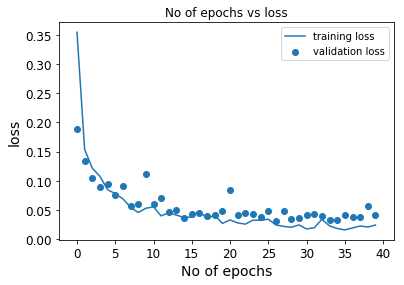

In [62]:
plot_LC(history)

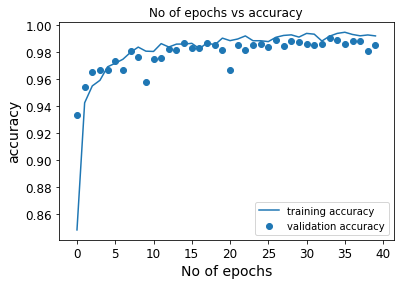

In [63]:
plot_acc(history)

### Predictions and submission

In [65]:
from tqdm import tqdm

test_path = 'input/test/'  # "../input/test/test/" for kernel submission
test_images_names = []

for filename in os.listdir(test_path):
    test_images_names.append(filename)

test_images_names.sort()

images_test = []

for image_id in tqdm(test_images_names):
    images_test.append(np.array(plt.imread(test_path + image_id)))
    
images_test = np.asarray(images_test)
images_test = images_test.astype('float32')
images_test /= 255

100%|██████████| 4000/4000 [00:26<00:00, 148.96it/s]


In [86]:
predict_proba = model.predict(images_test).reshape(-1)

In [87]:
predict_proba[:5]

array([9.9999988e-01, 1.0000000e+00, 8.1351079e-04, 6.2477356e-04,
       9.9976832e-01], dtype=float32)

In [88]:
predict = []
for i in tqdm(range(len(predict_proba))):
    if predict_proba[i]>0.5:
        answer = 1
    else:
        answer = 0
    predict.append(answer)

100%|██████████| 4000/4000 [00:00<00:00, 215100.79it/s]


In [89]:
predict[:5]

[1, 1, 0, 0, 1]

In [90]:
submission_df['has_cactus'] = predict_proba
submission_df.to_csv('submission_cnn_01.csv',index = False)